In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from plotting_functions import get_curve_idx_from_cluster_color, plot_specific_curves, \
                            plot_pca, plot_clusters_together, plot_clusters_seperately, \
                            pca_analysis
                            

# Load in all depth vs resistance curves into a dataframe list

In [2]:
def load_data(data_src):
    depth_resist_curve_df_list = [] # used for plotting
    filename_list = []
    for filename in os.listdir(data_src):
        df = pd.read_csv(f"{data_src}/{filename}")
        depth_resist_curve_df_list.append(df)
        filename_list.append(filename)
    return depth_resist_curve_df_list, filename_list

data_src = "data/cleaned_data"
depth_resist_curve_df_list, filename_list = load_data(data_src)
filename_to_depth_resist = dict(zip(filename_list, depth_resist_curve_df_list))

In [3]:
data_features_df = pd.read_csv("data/features.csv")
non_clustering_features_list = ['filenames', 'feifeis_ylabels', 'liams_ylabels', 'marions_ylabels', 'distances']
clustering_features_df = data_features_df.drop(non_clustering_features_list, axis=1)

# K-Means Clustering Implementation w/ k-means++ initialization for centroids

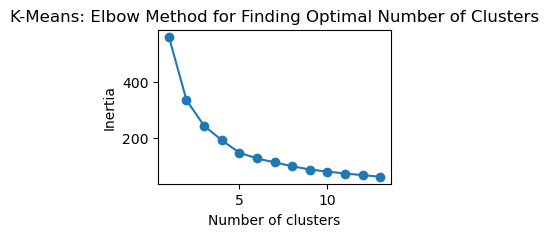

In [4]:
inertias = []
for k in range(1,14):
    kmeans = KMeans(n_clusters=k, init="k-means++", n_init=100).fit(clustering_features_df)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(3,2))
plt.plot(range(1,14), inertias, marker='o')
plt.title("K-Means: Elbow Method for Finding Optimal Number of Clusters")
plt.xlabel("Number of clusters")
plt.ylabel("Inertia")
plt.grid=True
plt.show()

# K-Means Clustering
- assumes
    - spherical clusters (isotropic)
    - similar size clusters (equal variance)
    - features are on same scale
    - clusters are linearly separable
    - number of clusters (k) is known

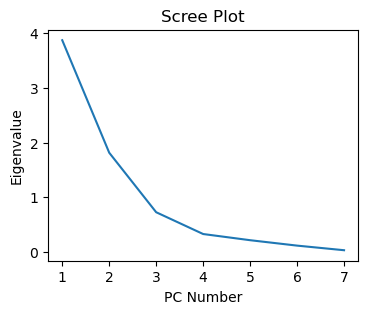

    Eigenvalue  Proportion  Cumulative
PC                                    
1     3.871505    0.546159    0.546159
2     1.813169    0.255786    0.801945
3     0.723959    0.102130    0.904075
4     0.325377    0.045901    0.949976
5     0.212310    0.029951    0.979927
6     0.113263    0.015978    0.995905
7     0.029025    0.004095    1.000000


                               PC1       PC2       PC3       PC4       PC5  \
overall_slope            -0.481679  0.183032 -0.047150  0.306434  0.122498   
max_depth                 0.484286 -0.082020  0.109266 -0.251518 -0.264406   
max_resistance           -0.445329  0.291402 -0.007045  0.249511 -0.263745   
num_peaks                 0.421298 -0.192023  0.108068  0.874110  0.077348   
largest_force_drop        0.261610  0.562749 -0.321552  0.112397 -0.620711   
curve_shape               0.087212  0.505580  0.843857 -0.039911  0.106548   
largest_force_drop_level  0.285652  0.515448 -0.398270 -0.047820  0.665511   

                      

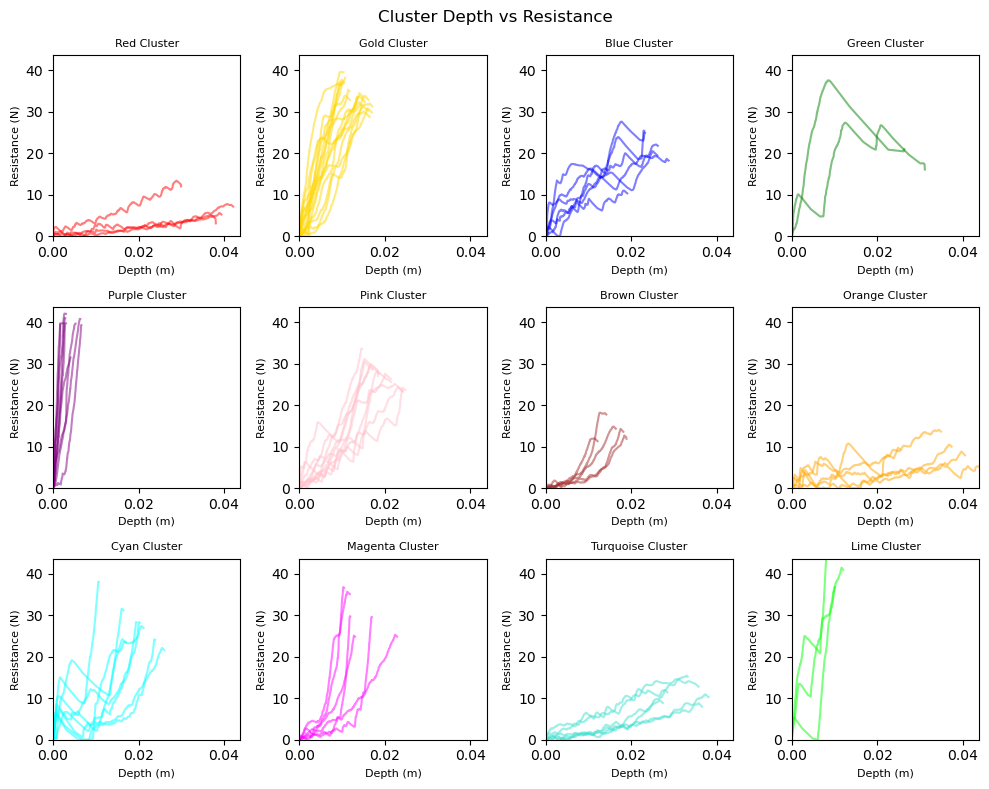

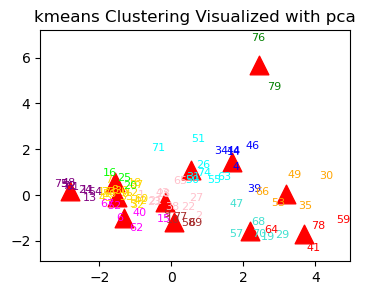

In [5]:
kmeans_elbow = 12
kmeans = KMeans(n_clusters=kmeans_elbow, init="k-means++", n_init=100).fit(clustering_features_df)
# print(f"kmeans cluster centers: {kmeans.cluster_centers_}")
pca_analysis(clustering_features_df) # printing scree plot
# plot_clusters_together(kmeans.labels_, "kmeans")
plot_clusters_seperately(kmeans.labels_, clustering_features_df.index.tolist(), depth_resist_curve_df_list, "kmeans")
plot_pca(clustering_features_df, y_labels=kmeans.labels_, graph_title="kmeans", kmeans_centroids=kmeans.cluster_centers_)

# Hierarchical Clustering

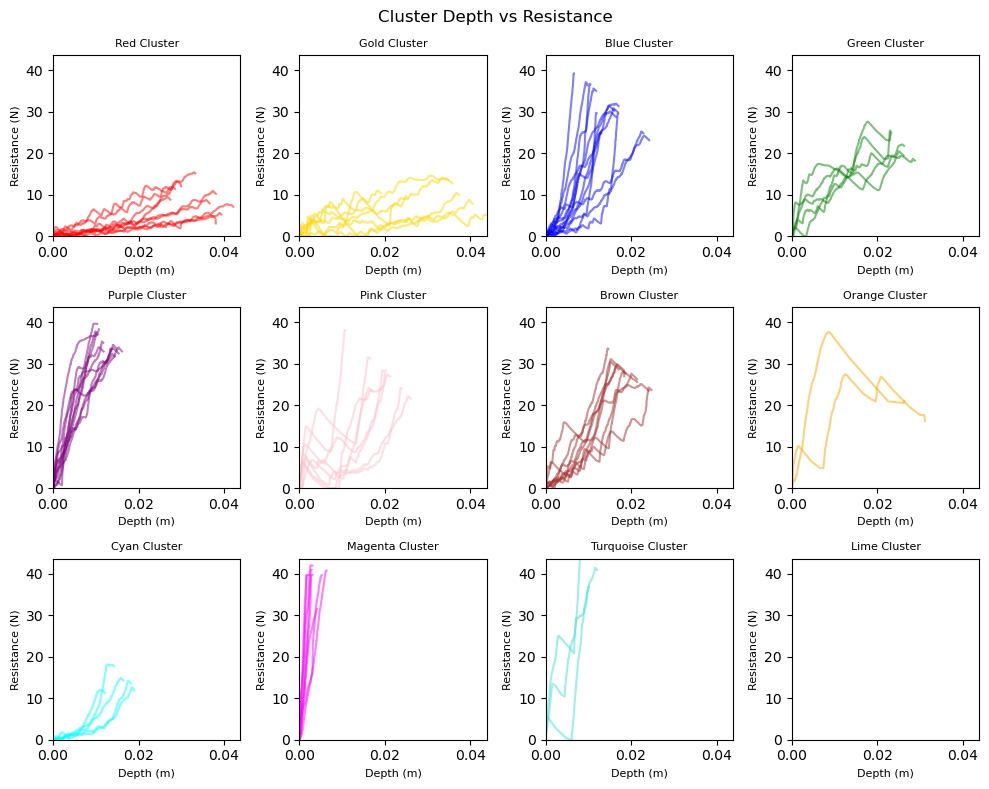

In [6]:

# if distance_threshold != None then n_clusters = None
hierarchical = AgglomerativeClustering(distance_threshold=None, n_clusters=11)
hierarchical.fit(clustering_features_df)
linkage = "Ward"
plot_clusters_seperately(hierarchical.labels_, clustering_features_df.index.tolist(), depth_resist_curve_df_list)

# DBSCAN

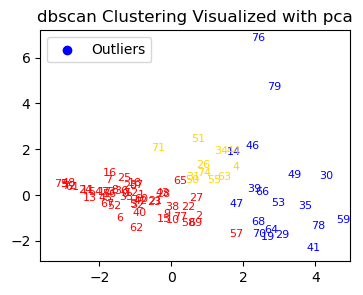

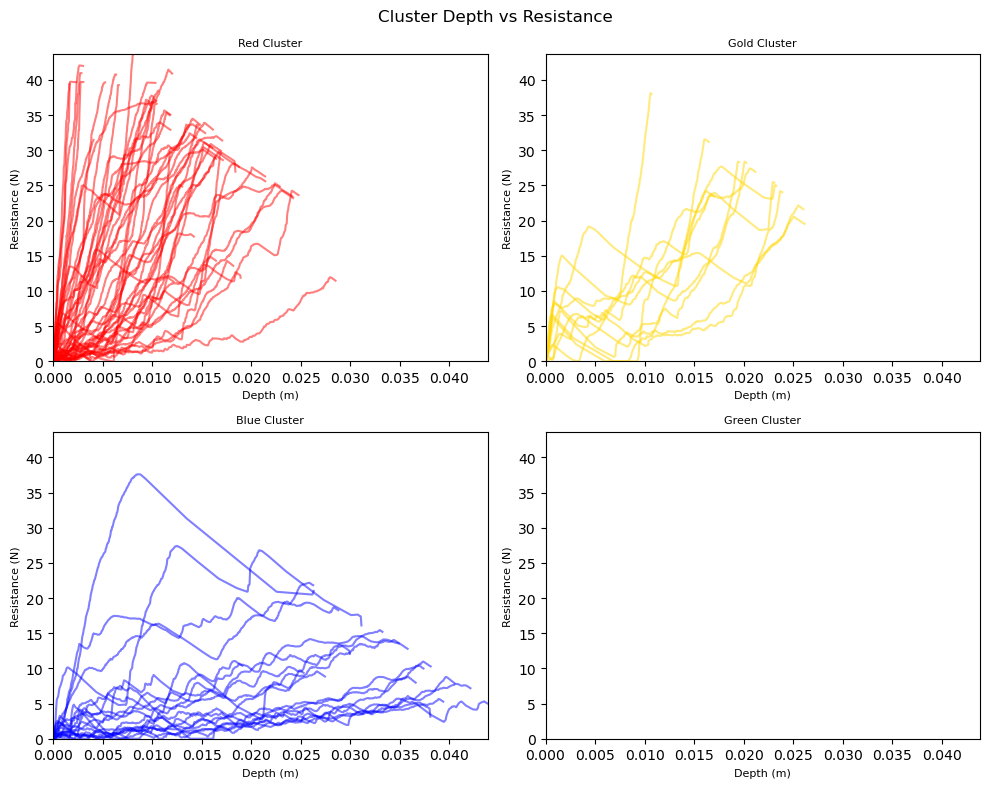

In [7]:

# eps=0.7, min_samples=3 works very well
dbscan = DBSCAN(eps=1.8, min_samples=10).fit(clustering_features_df)
cleaned_db_labels = [label if label != -1 else max(dbscan.labels_)+1 for label in dbscan.labels_]
# get_curve_idx_from_cluster_color("yellow", cleaned_db_labels)
plot_pca(clustering_features_df, cleaned_db_labels, 'dbscan')
plot_clusters_seperately(cleaned_db_labels, clustering_features_df.index.to_list(), depth_resist_curve_df_list)